In [1]:
import os
import tensorflow as tf
import numpy as np
import keras
import pandas as pd 
import imageio.v2 as imageio
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2DTranspose, BatchNormalization, ReLU, Conv2D, UpSampling2D, MaxPool2D, Dropout
from keras import Input, Model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
def preprocess_images_and_masks(folder_path):
  
  # Sort the list of filenames
  filenames = sorted(os.listdir(folder_path))

  # Load the images and masks from the folder
  # Taking out multiple masks for one image 
  images = [cv2.imread(os.path.join(folder_path, f)) for f in filenames if f.endswith('.png') and not (f.endswith('_mask.png') or f.endswith('_mask_1.png') or f.endswith('_mask_2.png'))]
  masks = [cv2.imread(os.path.join(folder_path, f), cv2.IMREAD_GRAYSCALE) for f in filenames if f.endswith('_mask.png')]

  # Resize the images and masks to a desired size
  desired_size = (256, 256)
  images = [cv2.resize(image, desired_size) for image in images]
  masks = [cv2.resize(mask, desired_size, interpolation=cv2.INTER_NEAREST) for mask in masks]

  # Convert the images to RGB format (if they are not already)
  images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

  # Normalize the pixel values of the images and masks
  images = [image / 255.0 for image in images]
  masks = [mask / 255.0 for mask in masks]

  # Convert the images and masks to numpy arrays
  images = np.array(images)
  masks = np.array(masks)

  return images, masks

In [3]:
# Define the paths to the three folders
benign_folder = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/'
malignant_folder = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/'
normal_folder = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/'

# Preprocess the images and masks from the folders
benign_images, benign_masks = preprocess_images_and_masks(benign_folder)
malignant_images, malignant_masks = preprocess_images_and_masks(malignant_folder)
normal_images, normal_masks = preprocess_images_and_masks(normal_folder)

# Concatenate the images and masks from the three folders
images = np.concatenate((benign_images, malignant_images, normal_images), axis=0)
masks = np.concatenate((benign_masks, malignant_masks, normal_masks), axis=0)

In [4]:
# Check the dimensions of the images and masks arrays
if len(images) == 0 or len(masks) == 0:
  print("Error: Images or masks array is empty")
elif len(images) != len(masks):
  print("Error: Mismatch in number of images and masks")
else:
  # Shuffle the images and masks together
  combined = list(zip(images, masks))
  np.random.shuffle(combined)
  images, masks = zip(*combined)

  # Convert the images and masks to numpy arrays
  images = np.array(images)
  masks = np.array(masks)

  # Calculate the number of images in each split
  num_images = len(images)
  num_train = int(0.90 * num_images)
  num_val = int(0.075 * num_images)
  num_test = num_images - num_train - num_val

  # Split the images and masks into training, validation, and test sets
  train_images = images[:num_train]
  train_masks = masks[:num_train]
  val_images = images[num_train:num_train+num_val]
  val_masks = masks[num_train:num_train+num_val]
  test_images = images[num_train+num_val:]
  test_masks = masks[num_train+num_val:]



# Visualize Image and Mask Pairings

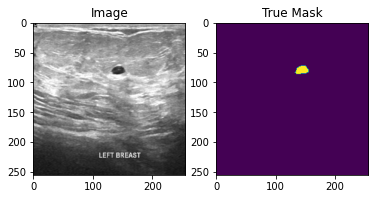

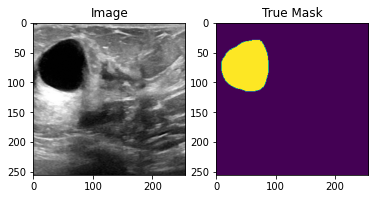

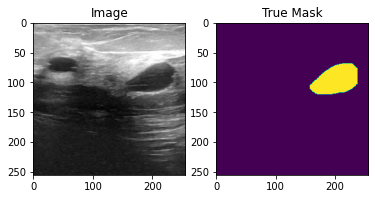

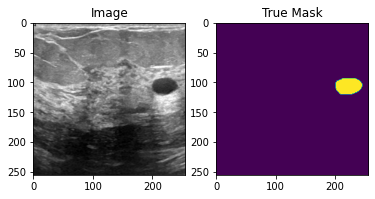

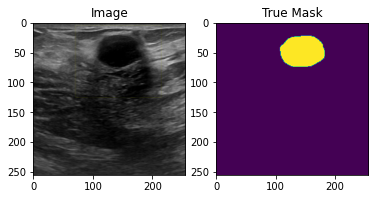

In [5]:
for i in range(5):
    image = benign_images[i]
    mask = benign_masks[i]
    
    # Display the image and the true mask
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(mask)
    ax2.set_title("True Mask")

    plt.show()

# Defining and Fitting Model

In [6]:
def create_upsample_layer(filters, kernel_size, padding='same', kernel_initializer='he_normal'):
    """ This function creates a layer that upsamples an input tensor using a convolutional, batch
    normalization, and ReLU activation, followed by an upsampling operation. """
    def layer(x):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = UpSampling2D(size=(2, 2))(x)
        return x
    return layer

def create_downsample_layer(filters, kernel_size, padding='same', kernel_initializer='he_normal'):
    """ This function creates a layer that downsamples an input tensor using a convolutional, batch
    normalization, and ReLU activation, followed by a max pooling operation. """
    def layer(x):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        return x
    return layer

dropout_rate = 0.15

# Example usage
inputs = Input(shape=(256, 256, 3))
# Encoder part of the DeepUNet
x = create_downsample_layer(64, 3, padding='same', kernel_initializer='he_normal')(inputs)
x = create_downsample_layer(128, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(256, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(512, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(1024, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(2048, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)

# Decoder part of the DeepUNet
x = create_upsample_layer(1024, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(512, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(256, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(128, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(64, 3, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(32, 3, padding='same', kernel_initializer='he_normal')(x)
outputs = Conv2D(1, 1, padding = 'same', activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)


In [7]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512   

In [8]:
# Define early stopping and reduce learning rate on plateau callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, 
                              verbose=1, mode='auto')

In [9]:
def dice_loss(y_true, y_pred):
    # Flatten the predictions and ground truth
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    
    # Compute the intersection and union
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    
    # Compute the Dice loss
    dice_loss = 1 - 2 * intersection / union
    
    return dice_loss

# Compile the model with the Dice loss
model.compile(loss=dice_loss, optimizer='adam', metrics=['accuracy'])

In [10]:
# Define the number of epochs and the batch size
num_epochs = 50
batch_size = 16

# Set seed
# tf.random.set_seed(42)
tf.random.set_seed(1)

# Train the UNet model on the training data
history = model.fit(#dataset,
                    train_images, 
                    train_masks,
                    batch_size=batch_size, epochs=num_epochs,
                    callbacks=[early_stop, reduce_lr],
                    validation_data=(val_images, val_masks))


Epoch 1/50
44/44 [==============================] - 16s 165ms/step - loss: 0.7184 - accuracy: 0.7539 - val_loss: 0.8173 - val_accuracy: 0.3581
Epoch 2/50
44/44 [==============================] - 6s 127ms/step - loss: 0.6296 - accuracy: 0.8783 - val_loss: 0.8770 - val_accuracy: 0.5719
Epoch 3/50
44/44 [==============================] - 6s 128ms/step - loss: 0.5641 - accuracy: 0.9065 - val_loss: 0.8498 - val_accuracy: 0.5302
Epoch 4/50
44/44 [==============================] - 6s 128ms/step - loss: 0.4890 - accuracy: 0.9240 - val_loss: 0.5981 - val_accuracy: 0.8928
Epoch 5/50
44/44 [==============================] - 6s 128ms/step - loss: 0.4366 - accuracy: 0.9353 - val_loss: 0.5521 - val_accuracy: 0.9396
Epoch 6/50
44/44 [==============================] - 6s 128ms/step - loss: 0.3860 - accuracy: 0.9451 - val_loss: 0.4663 - val_accuracy: 0.9286
Epoch 7/50
44/44 [==============================] - 6s 128ms/step - loss: 0.3546 - accuracy: 0.9496 - val_loss: 0.5284 - val_accuracy: 0.8570
Epoch

# Visualizing Model Performance and Predictions

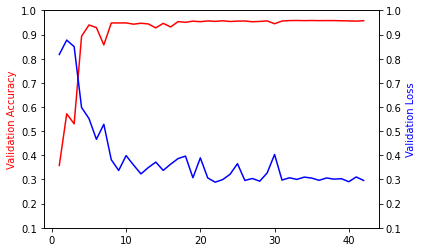

In [11]:
# Epochs and corresponding val_loss and val_accuracy values
epochs_list = list(range(1, len(history.history['val_loss']) + 1))
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plot the epoch vs val_loss
ax1 = plt.subplot(111)
ax1.plot(epochs_list, val_accuracy, 'r-')
ax1.set_ylabel('Validation Accuracy', color='r')

# Create a second y-axis for the val_accuracy
ax2 = ax1.twinx()
ax2.plot(epochs_list, val_loss, 'b-')
ax2.set_ylabel('Validation Loss', color='b')

# Set the same scaling on the y-axes
ax1.set_ylim([0.1, 1])
ax2.set_ylim([0.1, 1])

plt.show()


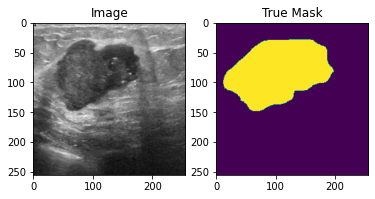

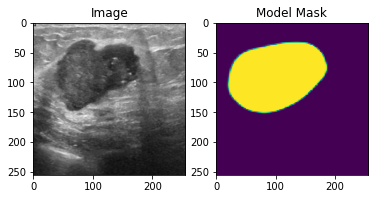

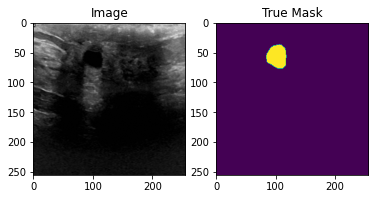

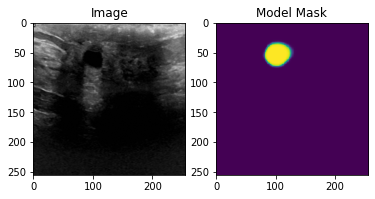

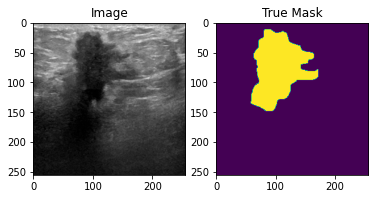

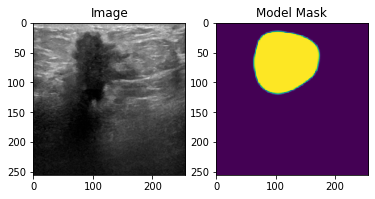

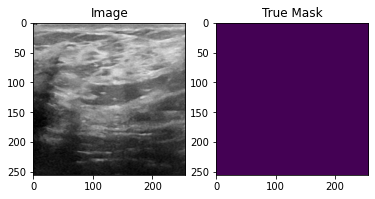

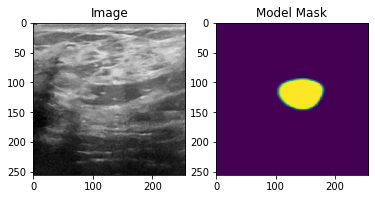

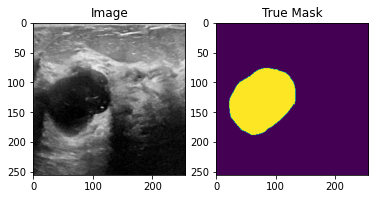

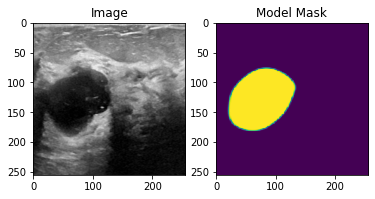

In [12]:
for i in range(5):
    # Select an image and its true mask
    image = test_images[i]
    mask = test_masks[i]

    # Make a prediction using the model
    prediction = model.predict(image[None, ...])[0]

    # Display the image and the true mask
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(mask)
    ax2.set_title("True Mask")

    # Display the image and the model's prediction
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(prediction)
    ax2.set_title("Model Mask")

    plt.show()


# Model Metrics

In [15]:
predictions = model.predict(test_images)

# Compute the mean IoU metric on the test set
mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou.update_state(test_masks, predictions)
print("Mean IoU on test set: {:.3f}".format(mean_iou.result()))

# Compute the precision and recall on the test set
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

precision.update_state(test_masks, predictions)
recall.update_state(test_masks, predictions)

# Get precision and recall values
precision_value = precision.result()
recall_value = recall.result()

print("Precision on test set: {:.3f}".format(precision_value))
print("Recall on test set: {:.3f}".format(recall_value))

# Compute the F1 score on the test set
f1_score = 2 * (precision_value * recall_value) / (precision_value + recall_value)
print("F1 score on test set: {:.3f}".format(f1_score))

# Reset the metrics
mean_iou.reset_states()
precision.reset_states()
recall.reset_states()


Mean IoU on test set: 0.791
Precision on test set: 0.788
Recall on test set: 0.821
F1 score on test set: 0.804


Overall the F1 score is good but I hope to tune the model in the future

In [ ]:
predictions = model.predict(images)

# Compute the mean IoU metric on the test set
mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou.update_state(masks, predictions)
print("Mean IoU on test set: {:.3f}".format(mean_iou.result()))

# Compute the precision and recall on the test set
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

precision.update_state(masks, predictions)
recall.update_state(masks, predictions)

# Get precision and recall values
precision_value = precision.result()
recall_value = recall.result()

print("Precision on test set: {:.3f}".format(precision_value))
print("Recall on test set: {:.3f}".format(recall_value))

# Compute the F1 score on the test set
f1_score = 2 * (precision_value * recall_value) / (precision_value + recall_value)
print("F1 score on test set: {:.3f}".format(f1_score))

# Reset the metrics
mean_iou.reset_states()
precision.reset_states()
recall.reset_states()